In [170]:
import tensorflow as tf
import pandas            as pd
import tensorflow        as tf  
import numpy             as np
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

from numpy                 import array
from sklearn               import metrics
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models          import Sequential
from tensorflow.keras.layers          import Dense,LSTM,Bidirectional

from numpy.random   import seed



In [161]:
# 确保结果尽可能重现

seed(1)
tf.random.set_seed(1)

# 设置相关参数
n_timestamp  = 32    # 时间戳
n_epochs     = 20    # 训练轮数
# ====================================
#      选择模型：
#            1: 单层 LSTM
#            2: 多层 LSTM
#            3: 双向 LSTM
# ====================================
model_type = 1

In [162]:
# 导入tushare
import tushare as ts

In [9]:
#pro=ts.get_hist_data('600848')
help(ts.pro_api)

Help on function pro_api in module tushare.pro.data_pro:

pro_api(token='', timeout=30)
    初始化pro API,第一次可以通过ts.set_token('your token')来记录自己的token凭证，临时token可以通过本参数传入



In [163]:

# 初始化pro接口
pro = ts.pro_api('84a7d42ba53be1e345b15650d19116113087ad5440320b4c6b7b6c67')

# 拉取数据
data = pro.daily(**{
    "ts_code": '600848.sh',
    "trade_date": "",
    "start_date": "2000-1-1",
    "end_date": "",
    "offset": "",
    "limit": ""
}, fields=[
    "trade_date",
    "open",
    "close",
    "high",
    "low",
    "vol",
    "ts_code"
])


In [164]:
print(data)
data.to_csv("stock600848.csv")

        ts_code trade_date   open   high    low  close       vol
0     600848.SH   20211022  15.25  15.50  15.21  15.25  46717.41
1     600848.SH   20211021  15.26  15.33  15.13  15.20  26697.95
2     600848.SH   20211020  15.19  15.40  15.13  15.26  31790.33
3     600848.SH   20211019  15.38  15.38  15.13  15.22  26657.53
4     600848.SH   20211018  15.39  15.45  15.23  15.37  28784.58
...         ...        ...    ...    ...    ...    ...       ...
4821  600848.SH   20000110  10.36  10.74  10.00  10.65  13267.00
4822  600848.SH   20000107  10.27  10.44  10.02  10.35  11930.00
4823  600848.SH   20000106   9.97  10.30   9.68  10.17   8910.00
4824  600848.SH   20000105   9.64  10.18   9.48  10.04   8457.00
4825  600848.SH   20000104   9.45   9.66   9.15   9.60   3826.00

[4826 rows x 7 columns]


In [166]:
data=pd.read_csv("./stock600848.csv",parse_dates=["trade_date"],index_col="trade_date")[["open","high","low","close"]]
# data=pd.read_csv("./stock688333.csv",parse_dates=["trade_date"])[["trade_date","open","high","low","close","vol"]]
data.index

DatetimeIndex(['2021-10-22', '2021-10-21', '2021-10-20', '2021-10-19',
               '2021-10-18', '2021-10-15', '2021-10-14', '2021-10-13',
               '2021-10-12', '2021-10-11',
               ...
               '2000-01-17', '2000-01-14', '2000-01-13', '2000-01-12',
               '2000-01-11', '2000-01-10', '2000-01-07', '2000-01-06',
               '2000-01-05', '2000-01-04'],
              dtype='datetime64[ns]', name='trade_date', length=4826, freq=None)

In [ ]:
# 获取股价数据
import pandas as pd
import numpy as np
import akshare as ak

pingan = ak.stock_zh_a_daily(symbol="sh601318", adjust="qfq")
df3 = pingan.reset_index().iloc[-30:,:6]  #取过去30天数据
df3 = df3.dropna(how='any').reset_index(drop=True) #去除空值且从零开始编号索引
df3 = df3.sort_values(by='date', ascending=True)
print(df3.info())

# 均线数据
df3['5'] = df3.close.rolling(5).mean()
df3['10'] = df3.close.rolling(10).mean()

df3.tail()

In [ ]:
import matplotlib
matplotlib.style.use('ggplot') #用于调整图标样式，可选
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick2_ohlc
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(1, 1, figsize=(8,3), dpi=200)

candlestick2_ohlc(ax,
                  opens = df3[ 'open'].values,
                highs = df3['high'].values,
                lows = df3[ 'low'].values,
                closes = df3['close'].values,
                  width=0.5, colorup="r",colordown="g")

# 显示最高点和最低点
ax.text( df3.high.idxmax(), df3.high.max(),   s =df3.high.max(), fontsize=8)
ax.text( df3.high.idxmin(), df3.high.min()-2, s = df3.high.min(), fontsize=8)

ax.set_facecolor("white")
ax.set_title("中国平安")

# 画均线
plt.plot(df3['5'].values, alpha = 0.5, label='MA5')
plt.plot(df3['10'].values, alpha = 0.5, label='MA10')

ax.legend(facecolor='white', edgecolor='white', fontsize=6)

# 修改x轴坐标
plt.xticks(ticks =  np.arange(0,len(df3)), labels = df3.date.dt.strftime('%Y-%m-%d').to_numpy() )
plt.xticks(rotation=90, size=8)

# 修改y轴坐标
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.show()

In [24]:
#from matplotlib.dates  import date2num
#data['date']=date2num(data.index.to_pydatetime())
#data=data.sort_values(by="date",ascending=True)
data

,open,high,low,close
trade_date,,,,
2021-10-22,15.25,15.50,15.21,15.25
2021-10-21,15.26,15.33,15.13,15.20
2021-10-20,15.19,15.40,15.13,15.26
2021-10-19,15.38,15.38,15.13,15.22
2021-10-18,15.39,15.45,15.23,15.37
...,...,...,...,...
1999-04-27,6.75,6.85,6.56,6.60
1999-04-26,7.31,7.48,6.90,6.98
1999-04-23,7.65,7.82,7.50,7.67


In [167]:
# 获取股价数据
import pandas as pd
import numpy as np

df3 = data.reset_index().iloc[:,:]  #取过去30天数据
df3 = df3.dropna(how='any').reset_index(drop=True) #去除空值且从零开始编号索引
print(df3)
df3 = df3.sort_values(by='trade_date', ascending=True)
print(df3.info())

# 均线数据
df3['5'] = df3.close.rolling(5).mean()
df3['10'] = df3.close.rolling(10).mean()

df3

     trade_date   open   high    low  close
0    2021-10-22  15.25  15.50  15.21  15.25
1    2021-10-21  15.26  15.33  15.13  15.20
2    2021-10-20  15.19  15.40  15.13  15.26
3    2021-10-19  15.38  15.38  15.13  15.22
4    2021-10-18  15.39  15.45  15.23  15.37
...         ...    ...    ...    ...    ...
4821 2000-01-10  10.36  10.74  10.00  10.65
4822 2000-01-07  10.27  10.44  10.02  10.35
4823 2000-01-06   9.97  10.30   9.68  10.17
4824 2000-01-05   9.64  10.18   9.48  10.04
4825 2000-01-04   9.45   9.66   9.15   9.60

[4826 rows x 5 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4826 entries, 4825 to 0
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   trade_date  4826 non-null   datetime64[ns]
 1   open        4826 non-null   float64       
 2   high        4826 non-null   float64       
 3   low         4826 non-null   float64       
 4   close       4826 non-null   float64       
dtype

,trade_date,open,high,low,close,5,10
4825,2000-01-04,9.45,9.66,9.15,9.60,NaN,NaN
4824,2000-01-05,9.64,10.18,9.48,10.04,NaN,NaN
4823,2000-01-06,9.97,10.30,9.68,10.17,NaN,NaN
4822,2000-01-07,10.27,10.44,10.02,10.35,NaN,NaN
4821,2000-01-10,10.36,10.74,10.00,10.65,10.162,NaN
...,...,...,...,...,...,...,...
4,2021-10-18,15.39,15.45,15.23,15.37,15.326,15.213
3,2021-10-19,15.38,15.38,15.13,15.22,15.342,15.228
2,2021-10-20,15.19,15.40,15.13,15.26,15.322,15.254
1,2021-10-21,15.26,15.33,15.13,15.20,15.288,15.269


ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of ticklabels (4826).

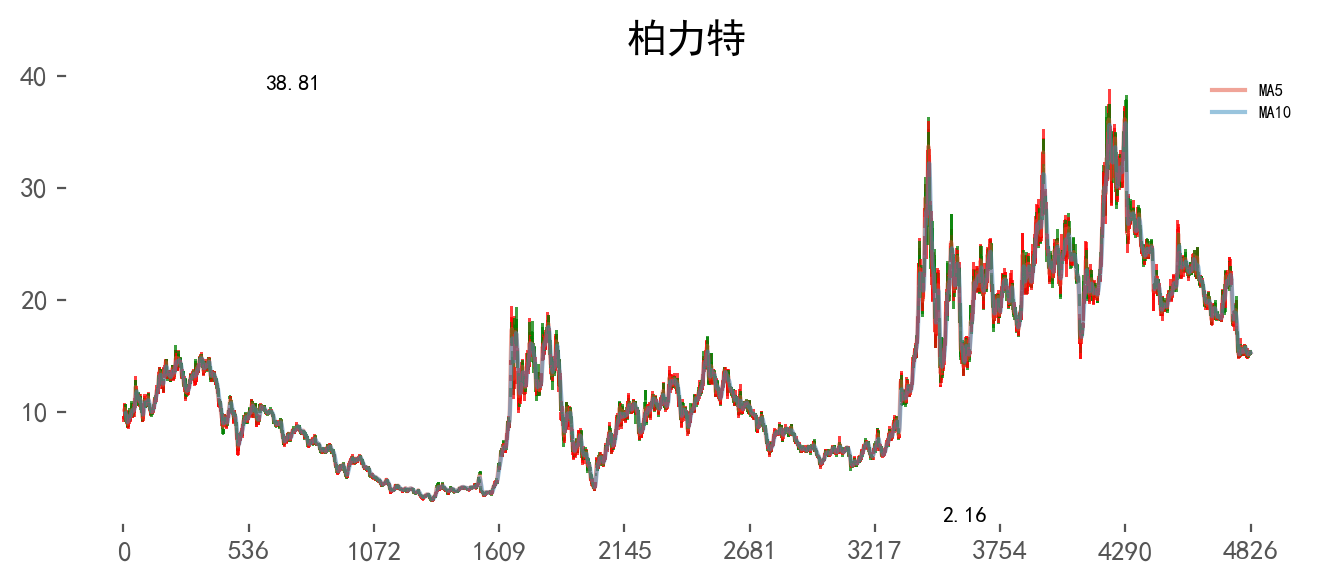

In [174]:
import matplotlib
matplotlib.style.use('ggplot') #用于调整图标样式，可选
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick2_ohlc
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(1, 1, figsize=(8,3), dpi=200)

candlestick2_ohlc(ax,
                  opens = df3[ 'open'].values,
                highs = df3['high'].values,
                lows = df3[ 'low'].values,
                closes = df3['close'].values,
                  width=0.5, colorup="r",colordown="g")

# 显示最高点和最低点
ax.text( df3.high.idxmax(), df3.high.max(),   s =df3.high.max(), fontsize=8)
ax.text( df3.high.idxmin(), df3.high.min()-2, s = df3.high.min(), fontsize=8)

ax.set_facecolor("white")
ax.set_title("柏力特")

# 画均线
plt.plot(df3['5'].values, alpha = 0.5, label='MA5')
plt.plot(df3['10'].values, alpha = 0.5, label='MA10')

ax.legend(facecolor='white', edgecolor='white', fontsize=6)

# 修改x轴坐标
plt.xticks(ticks =  np.linspace(0,len(df3),10),labels = df3.trade_date.dt.strftime('%Y-%m-%d').to_numpy())
plt.xticks(rotation=90, size=8)

# 修改y轴坐标
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.show()

In [173]:

 np.linspace(0,round(len(df3),0),10,dtype=int)

array([   0,  536, 1072, 1608, 2144, 2681, 3217, 3753, 4289, 4826])

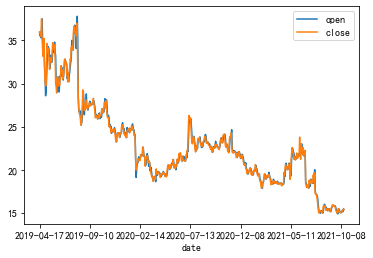

In [64]:
# data1=pd.DataFrame(data,columns=["trade_date","close"])
#data1=pd.DataFrame(data,columns=["close"])
data1=data.iloc[::-1]
data1["open"].plot(label="open")
data1["close"].plot(label="close")
plt.legend()
plt.show()


In [ ]:
ddd=[]
for item in data1.items():
    ddd.append(item)
ind=ddd[0][1].values
da1=ddd[1][1].values
index1=[]
data2=[]
for item in ind:
    index1.append(item)
index1.reverse()
for item in da1:
    data2.append(item)
data2.reverse()
data1={'trade_date':index1,'close':data2}
stockdata=pd.DataFrame(data1)

stockdata.items    

In [ ]:
df3.iloc[0:512,1:3].values[:,1]

In [129]:
from matplotlib.dates  import date2num
date2num(df3.trade_date.values)
df3['date']=date2num(df3.trade_date.values)
#df3=df3.sort_values(by="date",ascending=True)

#df3=df3[['date','open', 'high', 'low', 'close']]
ind=np.arange(0,540)
dataf1=df3[['date','open', 'high', 'low', 'close']]

In [131]:
dataf1.set_index("date")

,open,high,low,close
date,,,,
18099.0,61.00,96.00,43.40,64.33
18100.0,54.50,62.00,54.00,57.40
18101.0,61.21,68.00,61.18,67.99
18102.0,65.46,76.00,65.03,71.02
18103.0,68.00,70.79,66.18,67.34
...,...,...,...,...
18908.0,211.47,211.47,205.00,208.81
18911.0,208.64,216.33,206.34,210.08
18912.0,213.82,213.82,198.08,201.90


In [146]:
training_set = dataf1.iloc[0:300, :2].to_numpy()
test_set     = dataf1.iloc[606 - 300:, :2].to_numpy()
print(training_set)

[[18099.      61.  ]
 [18100.      54.5 ]
 [18101.      61.21]
 [18102.      65.46]
 [18103.      68.  ]
 [18106.      70.02]
 [18107.      79.57]
 [18108.      77.68]
 [18109.      82.  ]
 [18110.      91.  ]
 [18113.      97.47]
 [18114.      96.52]
 [18115.     107.9 ]
 [18116.      97.  ]
 [18117.      90.2 ]
 [18120.      87.5 ]
 [18121.      84.09]
 [18122.      92.  ]
 [18123.      89.5 ]
 [18124.      94.88]
 [18127.      90.8 ]
 [18128.      85.23]
 [18129.      84.4 ]
 [18130.      77.76]
 [18131.      76.  ]
 [18134.      75.5 ]
 [18135.      75.88]
 [18136.      75.9 ]
 [18137.      72.54]
 [18138.      73.99]
 [18141.      73.79]
 [18142.      73.4 ]
 [18143.      78.04]
 [18144.      76.55]
 [18145.      75.44]
 [18148.      71.8 ]
 [18149.      71.91]
 [18150.      71.75]
 [18151.      71.8 ]
 [18155.      68.3 ]
 [18156.      68.17]
 [18157.      67.6 ]
 [18158.      70.42]
 [18159.      74.63]
 [18162.      76.7 ]
 [18163.      74.66]
 [18164.      76.98]
 [18165.     

In [147]:
#将数据归一化，范围是0到1
sc  = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled  = sc.transform(test_set) 


In [159]:
# 取前 n_timestamp 天的数据为 X；n_timestamp+1天数据为 Y。
def data_split(sequence, n_timestamp):
    X = []
    y = []
    for i in range(len(sequence)):
        end_ix = i + n_timestamp
        
        if end_ix > len(sequence)-1:
            break
            
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

X_train, y_train = data_split(training_set_scaled, n_timestamp)

In [ ]:
X_train          = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

X_test, y_test   = data_split(testing_set_scaled, n_timestamp)
X_test           = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [152]:
help(np.reshape)
X_train.shape

Help on function reshape in module numpy:

reshape(a, newshape, order='C')
    Gives a new shape to an array without changing its data.
    
    Parameters
    ----------
    a : array_like
        Array to be reshaped.
    newshape : int or tuple of ints
        The new shape should be compatible with the original shape. If
        an integer, then the result will be a 1-D array of that length.
        One shape dimension can be -1. In this case, the value is
        inferred from the length of the array and remaining dimensions.
    order : {'C', 'F', 'A'}, optional
        Read the elements of `a` using this index order, and place the
        elements into the reshaped array using this index order.  'C'
        means to read / write the elements using C-like index order,
        with the last axis index changing fastest, back to the first
        axis index changing slowest. 'F' means to read / write the
        elements using Fortran-like index order, with the first index
        c

(268, 32, 2)

In [56]:
#五、构建模型
# 建构 LSTM模型
model_type=3
if model_type == 1:
    # 单层 LSTM
    model = Sequential()
    model.add(LSTM(units=50, activation='relu',
                   input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
if model_type == 2:
    # 多层 LSTM
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', return_sequences=True,
                   input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50, activation='relu'))
    model.add(Dense(1))
if model_type == 3:
    # 双向 LSTM
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'),
                            input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))

model.summary()  # 输出模型结构

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 100)               20800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


In [57]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')  # 损失函数用均方误差
#七、训练模型
history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=n_epochs,
                    validation_data=(X_test, y_test),
                    validation_freq=1)  # 测试的epoch间隔数

model.summary()

Epoch 1/20
8/8 [==============================] - 3s 100ms/step - loss: 0.0866 - val_loss: 0.0162
Epoch 2/20
8/8 [==============================] - 0s 42ms/step - loss: 0.0486 - val_loss: 0.0150
Epoch 3/20
8/8 [==============================] - 0s 40ms/step - loss: 0.0215 - val_loss: 0.0234
Epoch 4/20
8/8 [==============================] - 0s 39ms/step - loss: 0.0137 - val_loss: 0.0245
Epoch 5/20
8/8 [==============================] - 0s 42ms/step - loss: 0.0112 - val_loss: 0.0161
Epoch 6/20
8/8 [==============================] - 0s 39ms/step - loss: 0.0100 - val_loss: 0.0137
Epoch 7/20
8/8 [==============================] - 0s 44ms/step - loss: 0.0090 - val_loss: 0.0125
Epoch 8/20
8/8 [==============================] - 0s 44ms/step - loss: 0.0085 - val_loss: 0.0103
Epoch 9/20
8/8 [==============================] - 0s 41ms/step - loss: 0.0082 - val_loss: 0.0101
Epoch 10/20
8/8 [==============================] - 0s 39ms/step - loss: 0.0080 - val_loss: 0.0090
Epoch 11/20
8/8 [===========

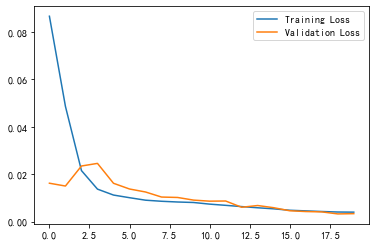

In [58]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
#plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [59]:
predicted_stock_price = model.predict(
    X_test)                        # 测试集输入模型进行预测
predicted_stock_price = sc.inverse_transform(
    predicted_stock_price)  # 对预测数据还原---从（0，1）反归一化到原始范围
real_stock_price = sc.inverse_transform(y_test)  # 对真实数据还原---从（0，1）反归一化到原始范围

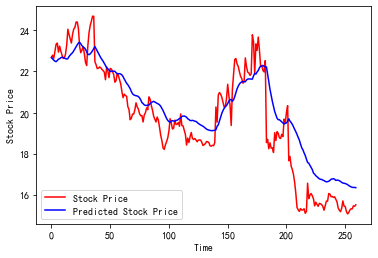

In [60]:
# 画出真实数据和预测数据的对比曲线
plt.plot(real_stock_price, color='red', label='Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Stock Price')
#plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [61]:
MSE = metrics.mean_squared_error(predicted_stock_price, real_stock_price)
RMSE = metrics.mean_squared_error(predicted_stock_price, real_stock_price)**0.5
MAE = metrics.mean_absolute_error(predicted_stock_price, real_stock_price)
R2 = metrics.r2_score(predicted_stock_price, real_stock_price)

print('均方误差: %.5f' % MSE)
print('均方根误差: %.5f' % RMSE)
print('平均绝对误差: %.5f' % MAE)
print('R2: %.5f' % R2)

均方误差: 1.40783
均方根误差: 1.18652
平均绝对误差: 0.93228
R2: 0.64628
